In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# file paths for the imputed pca+metadata csvs created earlier
train_csv = "/Users/dana/Desktop/AHI/01_PAML/Project/scr/Part_2/train_pca_data_imputed.csv"
val_csv   = "/Users/dana/Desktop/AHI/01_PAML/Project/scr/Part_2/val_pca_data_imputed.csv"   # optional: not required by this script
test_csv  = "/Users/dana/Desktop/AHI/01_PAML/Project/scr/Part_2/test_pca_data_imputed.csv"

In [4]:
# choose the target column here; to adapt to other targets just change this variable
target_col = "er" # options: "er", "relapse", "node", "grade", or for regression "size"

In [5]:
# whether to treat target as classification (True) or regression (False)
# this script focuses on classification; set to False if using size as regression (see notes below)
is_classification = True

In [10]:
df_train = pd.read_csv(train_csv)
df_test  = pd.read_csv(test_csv)
df_val  = pd.read_csv(val_csv)

In [11]:
df_test['er'].value_counts()

er
1.0    52
0.0    10
Name: count, dtype: int64

In [12]:
# basic safety checks
assert target_col in df_train.columns, f"target {target_col} not in train csv"
assert target_col in df_test.columns, f"target {target_col} not in test csv"

In [13]:
# features are all columns except the target
feature_cols = [c for c in df_train.columns if c != target_col]

In [ ]:
target = "er"   # change to: "relapse", "size", "grade", "node"

X_train = df_train.drop(columns=[target]).values
y_train = df_train[target].values

X_val   = df_val.drop(columns=[target]).values
y_val   = df_val[target].values

X_test  = df_test.drop(columns=[target]).values
y_test  = df_test[target].values

In [15]:
len(X_train)

184

In [16]:
len(X_test)

62

In [17]:
models = {
    "lr_cw": LogisticRegression(
        class_weight="balanced",
        max_iter=500,
        random_state=42
    ),
    "rf_cw": RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ),
    "svm_cw": SVC(
        C=1.0,
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=42
    ),
    "xgb_cw": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.8,
        eval_metric="logloss",
        scale_pos_weight=(sum(y_train==0)/sum(y_train==1)),  # imbalance-aware
        seed=42,
        random_state=42
    ),

    # SMOTE versions
    "rf_smote": IMBPipeline(steps=[
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(
            n_estimators=300, random_state=42
        ))
    ]),

    "svm_smote": IMBPipeline(steps=[
        ("smote", SMOTE(random_state=42)),
        ("svm", SVC(
            C=1.0, kernel="rbf", probability=True, random_state=42
        ))
    ]),

    "xgb_smote": IMBPipeline(steps=[
        ("smote", SMOTE(random_state=42)),
        ("xgb", XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.8,
            eval_metric="logloss",
            seed=42,
            random_state=42
        ))
    ])
}

In [18]:
models = {
    "lr_cw": LogisticRegression(
        class_weight="balanced",
        max_iter=500,
        random_state=42
    ),
    "rf_cw": RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ),
    "svm_cw": SVC(
        C=1.0,
        kernel="rbf",
        class_weight="balanced",
        probability=True,
        random_state=42
    ),
    "xgb_cw": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.8,
        eval_metric="logloss",
        scale_pos_weight=(sum(y_train==0)/sum(y_train==1)),  # imbalance-aware
        seed=42,
        random_state=42
    ),

    # SMOTE versions
    "rf_smote": IMBPipeline(steps=[
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(
            n_estimators=300, random_state=42
        ))
    ]),

    "svm_smote": IMBPipeline(steps=[
        ("smote", SMOTE(random_state=42)),
        ("svm", SVC(
            C=1.0, kernel="rbf", probability=True, random_state=42
        ))
    ]),

    "xgb_smote": IMBPipeline(steps=[
        ("smote", SMOTE(random_state=42)),
        ("xgb", XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.8,
            eval_metric="logloss",
            seed=42,
            random_state=42
        ))
    ])
}

In [19]:
results = []

for name, model in models.items():
    # scale only inside the pipeline (no leakage)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    results.append([name, acc, prec, rec, f1, auc])

results_df = pd.DataFrame(results, columns=["model", "accuracy", "precision", "recall", "f1", "roc_auc"])
results_df = results_df.sort_values("f1", ascending=False)
print(results_df)

       model  accuracy  precision    recall        f1   roc_auc
6  xgb_smote  0.935484   0.929825  1.000000  0.963636  0.844864
4   rf_smote  0.919355   0.913793  1.000000  0.954955  0.918239
2     svm_cw  0.919355   0.928571  0.981132  0.954128  0.867925
3     xgb_cw  0.919355   0.928571  0.981132  0.954128  0.880503
5  svm_smote  0.919355   0.928571  0.981132  0.954128  0.861635
0      lr_cw  0.919355   0.944444  0.962264  0.953271  0.855346
1      rf_cw  0.887097   0.883333  1.000000  0.938053  0.952830


Best model: xgb_smote


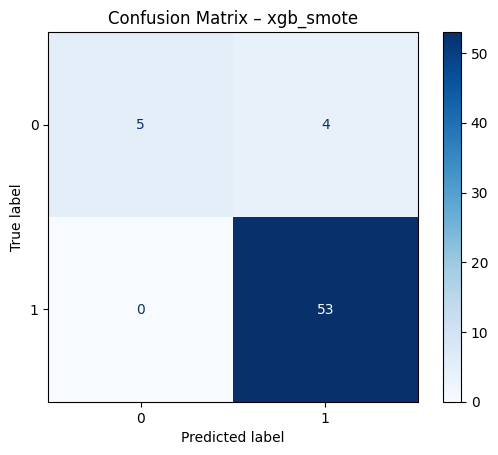

In [20]:
best_name = results_df.iloc[0]["model"]
print("Best model:", best_name)

best_model = models[best_name]

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", best_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix – {best_name}")
plt.show()

In [22]:
print("\nModel ranking by F1 score:\n")
print(results_df[["model", "f1"]])

best_model = results_df.iloc[0]["model"]
print(f"\nBest-performing model for target '{target}': {best_model}")


Model ranking by F1 score:

       model        f1
6  xgb_smote  0.963636
4   rf_smote  0.954955
2     svm_cw  0.954128
3     xgb_cw  0.954128
5  svm_smote  0.954128
0      lr_cw  0.953271
1      rf_cw  0.938053

Best-performing model for target 'er': xgb_smote


In [ ]:
# random search validation loss xgboost